In [2]:
import csv
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import pandas_datareader.data as web
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from matplotlib import pyplot
import scipy.stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AR
%matplotlib inline

In [3]:
fpath = 'facebook_data_Forbes_post_sentiment_4dict.tsv'
post_data = pd.read_csv(fpath, sep='\t')
post_data.head()

,ID,PostID,PostDate,Text,Likes,Shares,WNPositive,WNNegative,WNNeutral,WNSentiment,...,HVTokenQnt,HVSentiAvg,LMPositive,LMNegative,LMTokenQnt,LMSentiAvg,Vader_Positive,Vader_Negative,Vader_Neutral,Vader_Compound
0,1,10159570280702509,2021-05-15 16:33:10,Demand for travel is sky-high but many top hot...,189,12,0.125,0.250,17.625,-0.125,...,16,0.125000,0,0,16,0.000000,0.052,0.029,0.919,0.2382
1,2,10159573298827509,2021-05-16 19:30:09,"Ether prices recently surpassed $4,000, hittin...",4,3,1.625,0.750,12.625,0.875,...,16,0.250000,1,0,16,0.062500,0.229,0.000,0.771,0.7744
2,3,10159573296662509,2021-05-16 19:30:02,Clubhouse has launched to 2 billion Android us...,2,0,1.125,0.125,5.750,1.000,...,13,0.153846,0,1,13,-0.076923,0.186,0.000,0.814,0.5187
3,4,10159573166042509,2021-05-16 18:35:31,"""We now live in a country where members' votes...",57,13,0.750,1.000,11.250,-0.250,...,18,-0.166667,0,4,18,-0.222222,0.000,0.294,0.706,-0.8779
4,5,10159573151372509,2021-05-16 18:30:33,Both the Fed and the Treasury have dismissed s...,17,3,0.750,0.125,11.125,0.625,...,16,-0.125000,0,3,16,-0.187500,0.104,0.040,0.856,0.2748


In [4]:
post_data['Vader_Average'] = post_data['Vader_Positive'] - post_data['Vader_Negative']

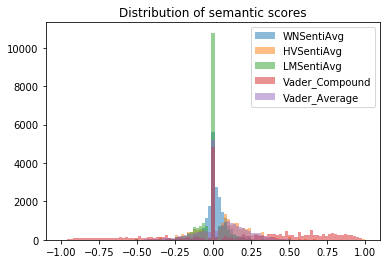

In [5]:
bins = np.linspace(-1, 1, 100)
pyplot.hist(post_data['WNSentiAvg'], bins, alpha=0.5, label='WNSentiAvg')
pyplot.hist(post_data['HVSentiAvg'], bins, alpha=0.5, label='HVSentiAvg')
pyplot.hist(post_data['LMSentiAvg'], bins, alpha=0.5, label='LMSentiAvg')
pyplot.hist(post_data['Vader_Compound'], bins, alpha=0.5, label='Vader_Compound')
pyplot.hist(post_data['Vader_Positive'] - post_data['Vader_Negative'], bins, alpha=0.5, label='Vader_Average')
pyplot.legend(loc='upper right')
pyplot.title('Distribution of semantic scores')
pyplot.show()

Text(0, 0.5, 'Posts')

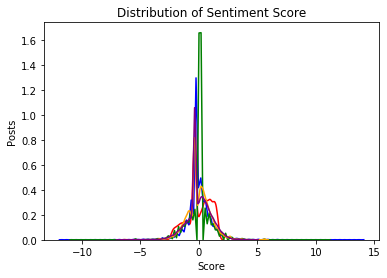

In [6]:


# seaborn histogram
sns.distplot((post_data['Vader_Compound'] - post_data['Vader_Compound'].mean())/post_data['Vader_Compound'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'red',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['WNSentiAvg'] - post_data['WNSentiAvg'].mean())/post_data['WNSentiAvg'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['LMSentiAvg'] - post_data['LMSentiAvg'].mean())/post_data['LMSentiAvg'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'green',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['HVSentiAvg'] - post_data['HVSentiAvg'].mean())/post_data['HVSentiAvg'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'orange',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['Vader_Average'] - post_data['Vader_Average'].mean())/post_data['Vader_Average'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'purple',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Distribution of Sentiment Score')
plt.xlabel('Score')
plt.ylabel('Posts')

In [7]:
post_data[['WNSentiAvg','HVSentiAvg','LMSentiAvg','Vader_Compound','Vader_Average']].describe()

,WNSentiAvg,HVSentiAvg,LMSentiAvg,Vader_Compound,Vader_Average
count,20395.000000,20395.000000,20395.000000,20395.000000,20395.000000
mean,0.016608,0.058649,-0.008783,0.178163,0.054961
std,0.071051,0.167449,0.091072,0.468883,0.156805
min,-0.812500,-1.000000,-1.000000,-0.984700,-1.000000
25%,-0.008929,0.000000,-0.037037,0.000000,0.000000
50%,0.005952,0.051282,0.000000,0.128000,0.027000
75%,0.048077,0.153846,0.000000,0.571900,0.152000
max,1.000000,1.000000,1.000000,0.989500,0.800000


In [8]:
post_data['PostDate'] = pd.to_datetime(post_data['PostDate'], errors='coerce')

post_data['DateMonth'] = post_data['PostDate'].dt.strftime('%Y-%m')
post_data['DateDay'] = post_data['PostDate'].dt.strftime('%Y-%m-%d')

In [9]:
post_data['DateMonth'].head()

0    2021-05
1    2021-05
2    2021-05
3    2021-05
4    2021-05
Name: DateMonth, dtype: object

In [10]:
post_data.columns

Index(['ID', 'PostID', 'PostDate', 'Text', 'Likes', 'Shares', 'WNPositive',
       'WNNegative', 'WNNeutral', 'WNSentiment', 'WNTokenQnt', 'WNSentiAvg',
       'HVPositive', 'HVNegative', 'HVTokenQnt', 'HVSentiAvg', 'LMPositive',
       'LMNegative', 'LMTokenQnt', 'LMSentiAvg', 'Vader_Positive',
       'Vader_Negative', 'Vader_Neutral', 'Vader_Compound', 'Vader_Average',
       'DateMonth', 'DateDay'],
      dtype='object')

In [11]:
Monthly_Data = post_data.groupby('DateMonth').agg({'WNSentiAvg': 'sum'
                                                         ,'WNTokenQnt':'count'
                                                        ,'Vader_Compound':'mean'
                                                        ,'Vader_Average': 'mean'
                                                        ,'HVPositive':'sum'
                                                        ,'HVNegative':'sum'
                                                        ,'HVTokenQnt':'sum'
                                                        ,'LMPositive':'sum'
                                                        ,'LMNegative':'sum'
                                                        ,'LMTokenQnt':'sum'
                                                       })

In [12]:
DailyData = post_data.groupby('DateDay').agg({'WNSentiAvg': 'sum'
                                                        ,'WNTokenQnt':'count'
                                                        ,'Vader_Compound':'mean'
                                                        ,'Vader_Average': 'mean'
                                                        ,'HVPositive':'sum'
                                                        ,'HVNegative':'sum'
                                                        ,'HVTokenQnt':'sum'
                                                        ,'LMPositive':'sum'
                                                        ,'LMNegative':'sum'
                                                        ,'LMTokenQnt':'sum'
                                                        })

In [13]:
DailyData['WNSentiment'] =  DailyData['WNSentiAvg']/ DailyData['WNTokenQnt']
DailyData['HVSentiment'] = (DailyData['HVPositive'] - DailyData['HVNegative'])/DailyData['HVTokenQnt']
DailyData['LMSentiment'] = (DailyData['LMPositive'] - DailyData['LMNegative'])/DailyData['LMTokenQnt']

Monthly_Data['WNSentiment'] =  Monthly_Data['WNSentiAvg']/ Monthly_Data['WNTokenQnt']
Monthly_Data['HVSentiment'] = (Monthly_Data['HVPositive'] - Monthly_Data['HVNegative'])/Monthly_Data['HVTokenQnt']
Monthly_Data['LMSentiment'] = (Monthly_Data['LMPositive'] - Monthly_Data['LMNegative'])/Monthly_Data['LMTokenQnt']



In [14]:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(DailyData['WNSentiment'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
for i in range(len(dfoutput)):
    dfoutput[i] = round(dfoutput[i],4)
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -16.5554
p-value                           0.0000
#Lags Used                        8.0000
Number of Observations Used    3298.0000
Critical Value (1%)              -3.4323
Critical Value (5%)              -2.8624
Critical Value (10%)             -2.5672
dtype: float64


In [15]:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(DailyData['HVSentiment'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
for i in range(len(dfoutput)):
    dfoutput[i] = round(dfoutput[i],4)
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   -6.5336
p-value                           0.0000
#Lags Used                       25.0000
Number of Observations Used    3281.0000
Critical Value (1%)              -3.4323
Critical Value (5%)              -2.8624
Critical Value (10%)             -2.5672
dtype: float64


In [16]:
for i in range(len(dfoutput)):
    dfoutput[i] = round(dfoutput[i],4)
print(dfoutput)
print('Results of Dickey-Fuller Test:')
dftest = adfuller(DailyData['LMSentiment'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value


Test Statistic                   -6.5336
p-value                           0.0000
#Lags Used                       25.0000
Number of Observations Used    3281.0000
Critical Value (1%)              -3.4323
Critical Value (5%)              -2.8624
Critical Value (10%)             -2.5672
dtype: float64
Results of Dickey-Fuller Test:


In [17]:
for i in range(len(dfoutput)):
    dfoutput[i] = round(dfoutput[i],4)
print(dfoutput)
print('Results of Dickey-Fuller Test:')
dftest = adfuller(DailyData['Vader_Compound'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value


Test Statistic                   -6.8210
p-value                           0.0000
#Lags Used                       27.0000
Number of Observations Used    3279.0000
Critical Value (1%)              -3.4323
Critical Value (5%)              -2.8624
Critical Value (10%)             -2.5672
dtype: float64
Results of Dickey-Fuller Test:


In [18]:
DailyData.head()

,WNSentiAvg,WNTokenQnt,Vader_Compound,Vader_Average,HVPositive,HVNegative,HVTokenQnt,LMPositive,LMNegative,LMTokenQnt,WNSentiment,HVSentiment,LMSentiment
DateDay,,,,,,,,,,,,,
2009-06-12,-0.035714,1,0.00000,0.0000,0,0,14,0,0,14,-0.035714,0.000000,0.000000
2009-06-13,0.035714,2,0.13660,0.0285,5,2,27,0,0,27,0.017857,0.111111,0.000000
2009-06-14,0.083333,1,0.20230,0.1410,5,0,19,2,0,19,0.083333,0.263158,0.105263
2009-06-15,-0.031250,2,0.46710,0.1560,6,1,37,2,0,37,-0.015625,0.135135,0.054054
2009-06-16,-0.058036,2,-0.02625,-0.0290,3,5,46,0,2,46,-0.029018,-0.043478,-0.043478


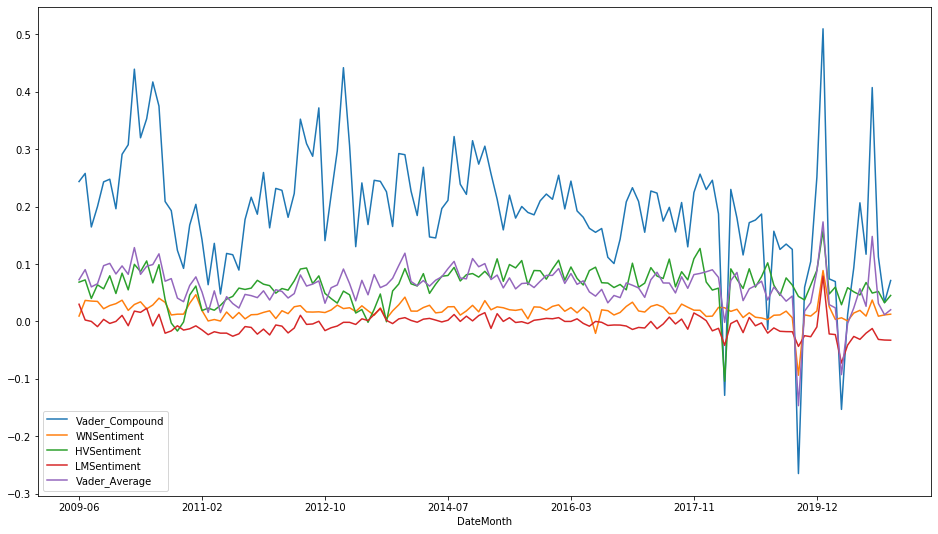

In [19]:
Monthly_Data[['Vader_Compound','WNSentiment','HVSentiment','LMSentiment','Vader_Average']].plot(legend=True, figsize=(16,9))

## Download S&P from Yahoo

In [20]:
SnP_daily = web.get_data_yahoo('^GSPC','10/01/2010','05/01/2021',interval='d')
SnP_monthly = web.get_data_yahoo('^GSPC','10/01/2010','05/01/2021',interval='m')

In [21]:
SnP_daily['LogReturn'] = np.log(SnP_daily['Adj Close']/SnP_daily['Adj Close'].shift(1))

In [22]:
SnP_monthly.index = SnP_monthly.index.strftime('%Y-%m')

In [23]:
SnP_monthly['LogReturn'] = np.log(SnP_monthly['Adj Close']/SnP_monthly['Adj Close'].shift(1))

## Granger test

In [24]:
Granger_data_daily = pd.merge(SnP_daily,DailyData, how= 'inner', left_index=True, right_index=True)

In [25]:
def grangerTest(exog, endog):
    MAX_LAG = 30
    ARaic = AR(exog.tolist()).fit(maxlag=MAX_LAG, ic="aic")
    ARbic = AR(exog.tolist()).fit(maxlag=MAX_LAG, ic="bic")
    # select the fewer number of parameters between both criteria.
    numExog = len(ARaic.params) if len(ARaic.params) < len(ARbic.params) else len(ARbic.params)

    print ("Optimal number of lags for exog data is " + str(numExog))

    ARaic = AR(endog.tolist()).fit(maxlag=MAX_LAG, ic="aic")
    ARbic = AR(endog.tolist()).fit(maxlag=MAX_LAG, ic="bic")
    # select the fewer number of parameters between both criteria.
    numEndog = len(ARaic.params) if len(ARaic.params) < len(ARbic.params) else len(ARbic.params)

    print ("Optimal number of lags for endog data is " + str(numEndog))

    # now that I know the optimal number of parameters, I can call the
    # granger causality function of statsmodels.
    data = pd.concat([endog, exog], axis=1)
    print ("\nGranger causality results of indep onto dep")
    results = grangercausalitytests(data, maxlag=numEndog)

    data = pd.concat([exog, endog], axis=1)
    print ("\nGranger causality results of dep onto indep")
    results = grangercausalitytests(data, maxlag=numExog)
    regr = results[2][1]
    print (regr[0].params)
    print (regr[1].params)
    print (regr[1].pvalues)

In [26]:
Granger_data_monthly = pd.merge(SnP_monthly,Monthly_Data, how= 'inner', left_index=True, right_index=True)

In [27]:
#Granger_data['SS_LogReturn'] = np.log((Granger_data['SentimentScoreAdj']+1)/(Granger_data['SentimentScoreAdj']+1).shift(1))

In [28]:
Granger_data_monthly

,High,Low,Open,Close,Volume,Adj Close,LogReturn,WNSentiAvg,WNTokenQnt,Vader_Compound,Vader_Average,HVPositive,HVNegative,HVTokenQnt,LMPositive,LMNegative,LMTokenQnt,WNSentiment,HVSentiment,LMSentiment
2010-10,1196.140015,1131.869995,1143.489990,1183.260010,89536270000,1183.260010,NaN,1.589779,126,0.123750,0.040619,173,204,1848,33,47,1848,0.012617,-0.016775,-0.007576
2010-11,1227.079956,1173.000000,1185.709961,1180.550049,87151070000,1180.550049,-0.002293,1.175275,93,0.092353,0.034355,101,102,994,21,36,994,0.012637,-0.001006,-0.015091
2010-12,1262.599976,1186.599976,1186.599976,1257.640015,80984530000,1257.640015,0.063256,2.749989,87,0.167828,0.062575,133,90,935,21,33,935,0.031609,0.045989,-0.012834
2011-01,1302.670044,1257.619995,1257.619995,1286.119995,92164940000,1286.119995,0.022393,4.097776,88,0.203903,0.077602,153,89,1039,34,42,1039,0.046566,0.061598,-0.007700
2011-02,1344.069946,1289.140015,1289.140015,1327.219971,59223660000,1327.219971,0.031457,1.834404,97,0.142337,0.051247,143,120,1214,27,45,1214,0.018911,0.018946,-0.014827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12,3760.199951,3633.399902,3645.870117,3756.070068,96056410000,3756.070068,0.036449,3.801737,411,0.116962,0.026304,798,433,5385,131,241,5385,0.009250,0.067781,-0.020427
2021-01,3870.899902,3662.709961,3764.610107,3714.239990,105548790000,3714.239990,-0.011199,0.223531,6,0.407283,0.148000,13,9,81,2,3,81,0.037255,0.049383,-0.012346
2021-03,3994.409912,3723.340088,3842.510010,3972.889893,120863560000,3972.889893,0.041563,7.426541,817,0.112596,0.031279,1909,1224,13137,303,715,13137,0.009090,0.052143,-0.031362
2021-04,4218.779785,3992.780029,3992.780029,4181.169922,82869290000,4181.169922,0.051097,1.355735,120,0.032910,0.011625,246,185,1881,34,95,1881,0.011298,0.032430,-0.032430


In [29]:
Vars = ["Vader_Compound","Vader_Average","WNSentiment","HVSentiment","LMSentiment"]
for Var in Vars:
    print("\n" + Var + "\n")
    grangerTest(Granger_data_daily[Var][1:], Granger_data_daily['LogReturn'][1:])


Vader_Compound



C:\Users\Windows\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarning)


Optimal number of lags for exog data is 9
Optimal number of lags for endog data is 9

Granger causality results of indep onto dep

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0046  , p=0.9462  , df_denom=2053, df_num=1
ssr based chi2 test:   chi2=0.0046  , p=0.9461  , df=1
likelihood ratio test: chi2=0.0046  , p=0.9461  , df=1
parameter F test:         F=0.0046  , p=0.9462  , df_denom=2053, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1061  , p=0.8993  , df_denom=2050, df_num=2
ssr based chi2 test:   chi2=0.2127  , p=0.8991  , df=2
likelihood ratio test: chi2=0.2127  , p=0.8991  , df=2
parameter F test:         F=0.1061  , p=0.8993  , df_denom=2050, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0861  , p=0.9677  , df_denom=2047, df_num=3
ssr based chi2 test:   chi2=0.2591  , p=0.9675  , df=3
likelihood ratio test: chi2=0.2591  , p=0.9675  , df=3
parameter F test:         F=0.08

Optimal number of lags for exog data is 3
Optimal number of lags for endog data is 9

Granger causality results of indep onto dep

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5525  , p=0.4574  , df_denom=2053, df_num=1
ssr based chi2 test:   chi2=0.5533  , p=0.4570  , df=1
likelihood ratio test: chi2=0.5532  , p=0.4570  , df=1
parameter F test:         F=0.5525  , p=0.4574  , df_denom=2053, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2447  , p=0.7829  , df_denom=2050, df_num=2
ssr based chi2 test:   chi2=0.4907  , p=0.7824  , df=2
likelihood ratio test: chi2=0.4906  , p=0.7825  , df=2
parameter F test:         F=0.2447  , p=0.7829  , df_denom=2050, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2279  , p=0.8771  , df_denom=2047, df_num=3
ssr based chi2 test:   chi2=0.6859  , p=0.8765  , df=3
likelihood ratio test: chi2=0.6858  , p=0.8765  , df=3
parameter F test:         F=0.22

Optimal number of lags for exog data is 3
Optimal number of lags for endog data is 9

Granger causality results of indep onto dep

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0053  , p=0.9419  , df_denom=2053, df_num=1
ssr based chi2 test:   chi2=0.0053  , p=0.9419  , df=1
likelihood ratio test: chi2=0.0053  , p=0.9419  , df=1
parameter F test:         F=0.0053  , p=0.9419  , df_denom=2053, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0489  , p=0.9523  , df_denom=2050, df_num=2
ssr based chi2 test:   chi2=0.0980  , p=0.9522  , df=2
likelihood ratio test: chi2=0.0980  , p=0.9522  , df=2
parameter F test:         F=0.0489  , p=0.9523  , df_denom=2050, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1263  , p=0.9445  , df_denom=2047, df_num=3
ssr based chi2 test:   chi2=0.3803  , p=0.9443  , df=3
likelihood ratio test: chi2=0.3803  , p=0.9443  , df=3
parameter F test:         F=0.12

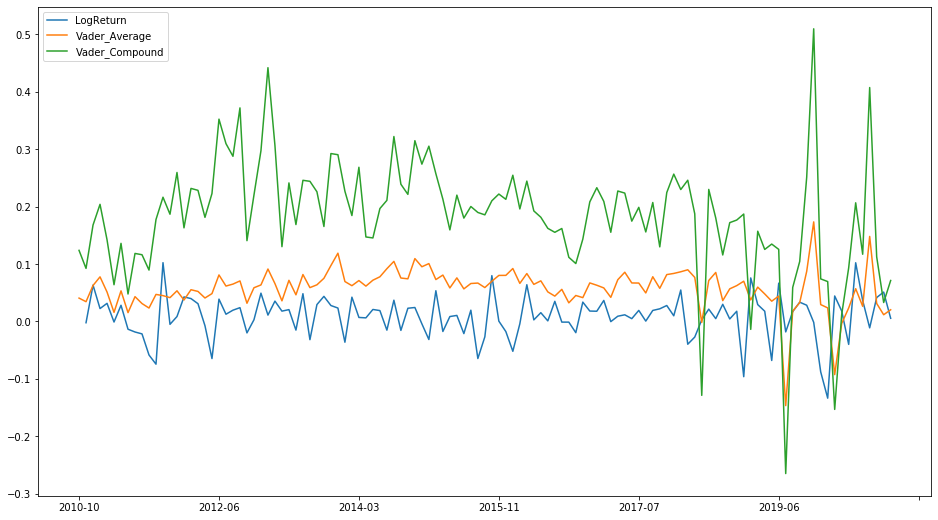

In [31]:
Granger_data_monthly[['LogReturn','Vader_Average','Vader_Compound']].plot(legend=True, figsize=(16,9))

In [34]:
corr = Granger_data_daily[['Vader_Compound','Flair_Score','SentimentScoreAdj','Vader_Average', 'LogReturn']].corr()
corr.style.background_gradient(cmap='coolwarm')

,Vader_Compound,Flair_Score,SentimentScoreAdj,Vader_Average,LogReturn
Vader_Compound,1.000000,0.237375,0.421607,0.904405,0.024251
Flair_Score,0.237375,1.000000,0.126345,0.236614,0.024030
SentimentScoreAdj,0.421607,0.126345,1.000000,0.378771,0.019746
Vader_Average,0.904405,0.236614,0.378771,1.000000,0.023152
LogReturn,0.024251,0.024030,0.019746,0.023152,1.000000


In [30]:
pvals = [] 
for col in ["Vader_Compound","Vader_Average","WNSentiment","HVSentiment","LMSentiment"]:
    pvals.append(scipy.stats.linregress(Granger_data_daily['LogReturn'][1:], Granger_data_daily[col][1:].dropna())[3])
corr_signif = pd.DataFrame(pvals,columns = ['p-value']
                           ,index = ["Vader_Compound","Vader_Average","WNSentiment","HVSentiment","LMSentiment"])
#print(corr_signif.to_latex())
print(corr_signif)

                 p-value
Vader_Compound  0.867280
Vader_Average   0.799289
WNSentiment     0.751068
HVSentiment     0.931319
LMSentiment     0.977753


In [38]:
pvals_mnt = [] 
for col in ['Vader_Compound','Flair_Score','SentimentScoreAdj','Vader_Average']:
    pvals_mnt.append(scipy.stats.linregress(Granger_data_monthly['LogReturn'][1:], Granger_data_monthly[col][1:].dropna())[3])
corr_signif_mnt = pd.DataFrame(pvals_mnt,columns = ['p-value']
                           ,index = ['Vader_Compound','Flair_Score','SentimentScoreAdj','Vader_Average'])
corr_signif_mnt

,p-value
Vader_Compound,0.084306
Flair_Score,0.977764
SentimentScoreAdj,0.311650
Vader_Average,0.047369
